1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt

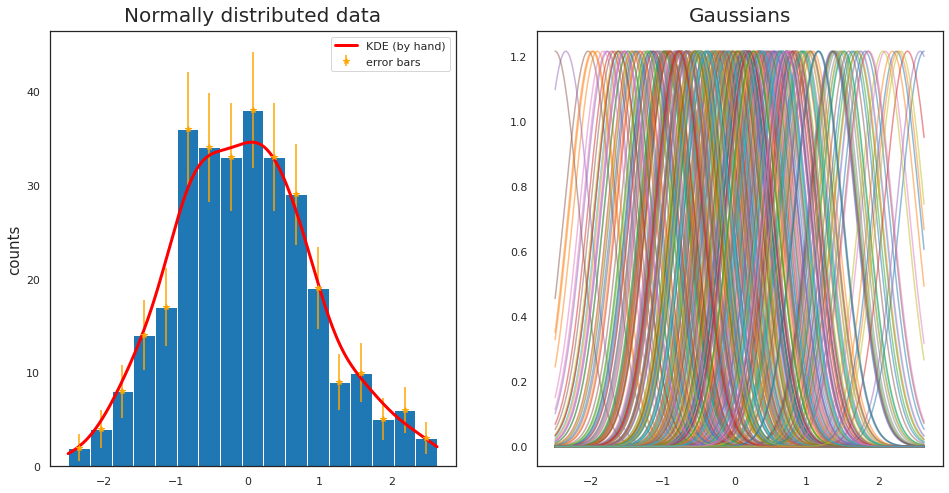

In [15]:
N = 300

x = np.random.normal(loc = 0, scale = 1, size = N)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
ax1.set_title('Normally distributed data', fontsize=20, verticalalignment='bottom')
ax1.set_ylabel('counts', fontsize = 15)
hist = ax1.hist(x, bins = int(np.sqrt(N))) #hist returns a tuple of the kind ([counts],[bins],[patches])
midpoint = (hist[1][1:] + hist[1][:-1])/2 #get the midpoints of the bins
ax1.errorbar(midpoint, hist[0], yerr = np.sqrt(hist[0]), fmt='*', color = 'orange', label = 'error bars')

std = 1.06 * x.std() * pow(x.size, -0.2)

xs=np.linspace(x.min(),x.max(), N)
gaussians = np.array([sp.stats.norm(a,std).pdf(xs) for a in x])
ax2.set_title('Gaussians',fontsize=20, verticalalignment='bottom')
for g in gaussians:
    ax2.plot(xs,g, alpha = 0.5)
    
    
    
kde = np.sum(gaussians, axis = 0) # We sum all the gaussians element by element 
integral= sp.integrate.trapz(kde,xs)
# Now we can normalize the KDE to the area of the histogram.
#The next line takes the KDE and it multiplies it by the fraction histAREA/unnormalizedKDE
# histAREA is calculated by taking the sum of the area of the rectangles
#(np.diff(hist[1]) is the distance between midpoints), remember that hist is [][]
kde_normalized = kde * np.sum(np.diff(hist[1])*hist[0])/integral

ax1.plot(xs, kde_normalized, color = 'red', linewidth = 3,label = 'KDE (by hand)')

ax1.legend()

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

--2021-12-11 12:53:24--  https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png [following]
--2021-12-11 12:53:25--  https://www.dropbox.com/s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc271cb281b89fb1a90e1ed3fab6.dl.dropboxusercontent.com/cd/0/inline/Bbqs-WsbGnDoAoYxsJoa7oMHYmcnbt-1O1FpCAmg5xGyJ2y_IdgylDJtBKmgikEPOkCHgERuDLWM4-ddMcjEO2OypFjuJXSm39_qwsgDryTsQWJI45sOFaDI-ZuL7bFbSPwZLtgcbwx-hQj9UrQer7Z-/file# [following]
--2021-12-11 12:53:25--  https://uc271cb281b89fb1a90e1ed3fab6.dl.dropboxusercontent.com/cd/0/inline/Bbqs-WsbGnDoAoYxsJoa7oMHYmcnbt

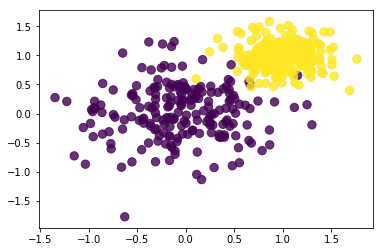

In [3]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

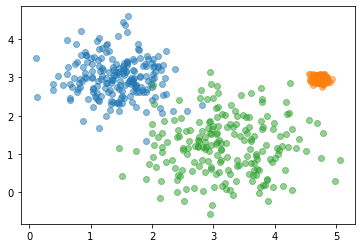

In [4]:
def createdata(num_categories, num_points):
    for i in range(num_categories):
        mean = np.random.uniform(0,5,size = 2)
        covariance_matrix = np.random.uniform() * np.eye(2) # i'll use spherical covariance for all distributions
        data_set = np.random.multivariate_normal(mean, covariance_matrix, num_points)
        df = pd.DataFrame(data_set, columns = ['x','y'])
        plt.scatter(x = 'x', y = 'y', data = df, alpha=0.5)

createdata(3,200)
    
    

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [5]:
df = pd.DataFrame(np.load('residuals_261.npy', allow_pickle = True).item())
df_absres_lt2 = df[abs(df['residuals']) < 2]
df_absres_lt2

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
8,-0.042857,3.3
9,0.128571,5.3
10,0.085714,15.0
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


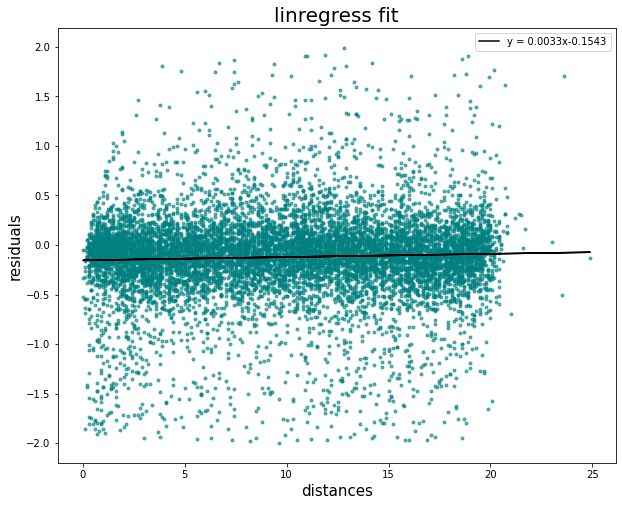

In [6]:
#linregress using scipy

x = df_absres_lt2['distances']
y = df_absres_lt2['residuals']

mod = sp.stats.linregress(x,y)
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('linregress fit', fontsize = 20)
ax.set_xlabel('distances', fontsize = 15)
ax.set_ylabel('residuals', fontsize = 15)
ax.scatter(x, y, marker = '.', color = 'teal', alpha = 0.6)
ax.plot(x, mod.intercept + mod.slope*x, color = 'k', label='y = {0:.4f}x{1:.4f}'.format(mod.slope,mod.intercept))
ax.legend()

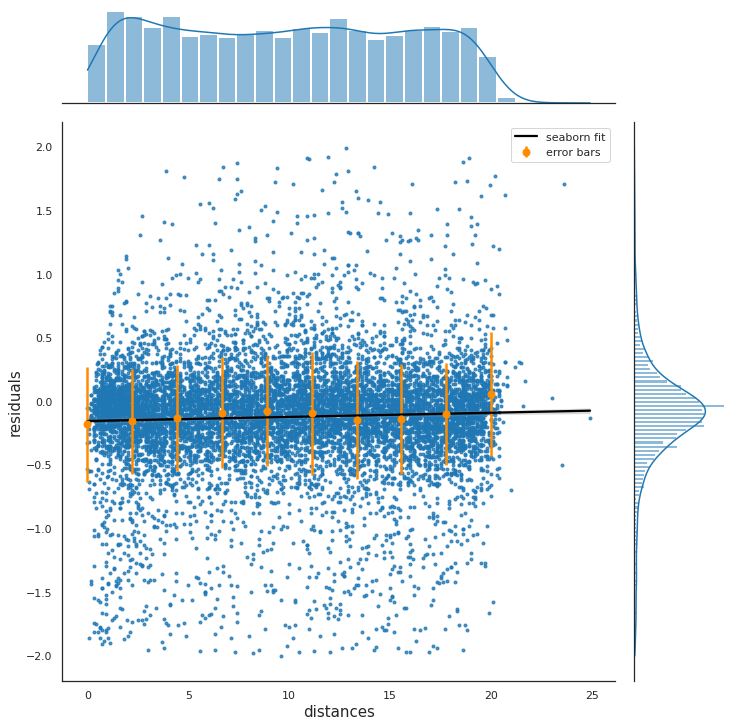

In [16]:
x = np.linspace(0,20,10) #bin centers range from 0 to 20 with 10 steps
df_absres_lt2['bin'] = np.digitize(df_absres_lt2['distances'], bins = x)
y = df_absres_lt2.groupby('bin')['residuals'].mean().values
yerr = df_absres_lt2.groupby('bin')['residuals'].std().values
sns.set(style = 'white', palette = 'tab10')
g = sns.JointGrid(height = 10)
sns.regplot(x = 'distances', y = 'residuals', data = df_absres_lt2, marker = '.', line_kws={'color': 'k','label':'seaborn fit'}, ax=g.ax_joint)
sns.histplot(x = 'distances', data = df_absres_lt2,kde = True, linewidth=2, ax=g.ax_marg_x)
sns.histplot(y= 'residuals',data = df_absres_lt2,kde= True, linewidth=2, ax=g.ax_marg_y)
g.ax_joint.set_xlabel('distances', fontsize = 15)
g.ax_joint.set_ylabel('residuals', fontsize = 15)
g.ax_joint.errorbar(x,y,yerr, fmt = 'o', color = 'darkorange', markersize = 7, linewidth = 2.5, label = 'error bars')
g.ax_joint.legend()